In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
import torch.nn.functional as  F

PATH = "/disk/vanishing_data/is789/models/ciffar10_tiny.pt"

In [2]:
train_data = datasets.CIFAR10(root='/disk/vanishing_data/is789/datasets/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

test_data = datasets.CIFAR10(root='/disk/vanishing_data/is789/datasets/',
                          train=False,
                          transform=transforms.ToTensor(),
                          download=True)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
## exclude label
## only take some categories
def discardLabels(data, size=3):
    new_data = []
    for img, tag in data:
#         img = img.numpy()
#         img = np.transpose(img, (1,2,0))
        if tag < size:
            new_data.append(img)
        
        
    return np.array(new_data)

train_data = discardLabels(train_data, 2)
test_data = discardLabels(test_data, 2)

/tmp/fzi-is789/ipykernel_215837/930371099.py:12: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(new_data)
/tmp/fzi-is789/ipykernel_215837/930371099.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(new_data)


In [4]:
len(train_data)

10000

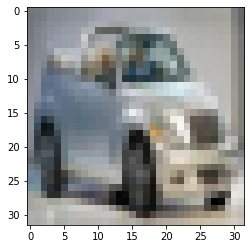

In [5]:
img = train_data[11]
img = img.numpy()
img = np.transpose(img, (1,2,0))
plt.imshow(img)

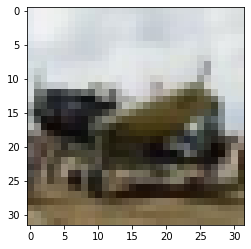

In [6]:
img = test_data[10]
img = img.numpy()
img = np.transpose(img, (1,2,0))
plt.imshow(img)

In [7]:
## apply noise
noise_set = []

for img in test_data:
    pic = img.numpy().copy()
    pic[:,10:15,:] = 0.0
    noise_set.append(pic)

noise_set = np.array(noise_set)
noise_set = torch.as_tensor(noise_set)
noise_set.shape

torch.Size([2000, 3, 32, 32])

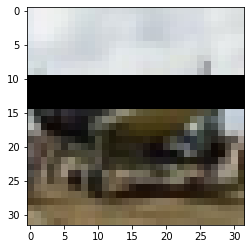

In [8]:
## show noisy image

img = noise_set[10]
# img = img.squeeze()
img = img.numpy()
img = np.transpose(img, (1,2,0))
plt.imshow(img)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [10]:
BATCH_SIZE = 128
class VAE(nn.Module):
    
    def __init__(self, imgChannels=3, imgSize=32, zDim=1024):
        super(VAE, self).__init__()
        
        stride=1
        padding=0
        kernel=3
        layers=[64, 128, 128, 256]

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(in_channels=imgChannels, out_channels=layers[0], kernel_size=kernel, stride=stride)
        self.encBn1 = nn.BatchNorm2d(layers[0])
        self.encConv2 = nn.Conv2d(in_channels=layers[0], out_channels=layers[1], kernel_size=kernel, stride=stride)
        self.encBn2 = nn.BatchNorm2d(layers[1])
        self.encConv3 = nn.Conv2d(in_channels=layers[1], out_channels=layers[2], kernel_size=kernel, stride=stride)
        self.encBn3 = nn.BatchNorm2d(layers[2])
        self.encConv4 = nn.Conv2d(in_channels=layers[2], out_channels=layers[3], kernel_size=kernel, stride=stride)
        self.encBn4 = nn.BatchNorm2d(layers[3])
        
        encoderDims = self.calcEncoderDims(len(layers), imgSize, kernel, padding, stride)
        featureDim = layers[-1] * encoderDims[-1] * encoderDims[-1]
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decBn1 = nn.BatchNorm1d(featureDim)
        self.decConv1 = nn.ConvTranspose2d(in_channels=layers[3], out_channels=layers[2], kernel_size=kernel, stride=stride)
        self.decBn2 = nn.BatchNorm2d(layers[2])
        self.decConv2 = nn.ConvTranspose2d(in_channels=layers[2], out_channels=layers[1], kernel_size=kernel, stride=stride)
        self.decBn3 = nn.BatchNorm2d(layers[1])
        self.decConv3 = nn.ConvTranspose2d(in_channels=layers[1], out_channels=layers[0], kernel_size=kernel, stride=stride)
        self.decBn4 = nn.BatchNorm2d(layers[0])
        self.decConv4 = nn.ConvTranspose2d(layers[0], imgChannels, kernel_size=3, stride=1)
        
        self.final_encoder_dim = None
        
        decoderDims = self.calcDecoderDims(len(layers), encoderDims[-1], kernel, padding, stride)
        self.printModel(layers, encoderDims, decoderDims, imgSize, imgChannels)

    def calcEncoderDims(self, layer_size, imageSize, kernel, padding, stride):
        newDims = [imageSize]
        for x in range(layer_size):
            tmpSize = int((newDims[-1]-kernel+2*padding)/stride)+1
            newDims.append(tmpSize)
        newDims.pop(0)
        return newDims
    
    def calcDecoderDims(self, layer_size, imageSize, kernel, padding, stride, d=1):
        newDims = [imageSize]
        for x in range(layer_size):
            tmpSize = (newDims[-1] - 1)*stride - 2*padding + d*(kernel - 1) + padding + 1
            newDims.append(tmpSize)
#         newDims.pop(0)
        return newDims
    
    
    def printModel(self, layers, encDims, decDims, imageSize, imgChannels):
        print("=============")
        print("Image Flow:")
        print("Encoder:")
        print(f"{imageSize}x{imageSize}x{imgChannels} (Input Image)")
        for x in range(len(layers)):
            print(f"{encDims[x]}x{encDims[x]}x{layers[x]}")
        
        print("Decoder:")
        k = len(layers) - 1
        for x in range(len(layers)):
            print(f"{decDims[x]}x{decDims[x]}x{layers[k]}")
            k = k - 1
        print(f"{decDims[-1]}x{decDims[-1]}x{imgChannels} (Output Image)")
        print("=============")
            
        
    def encoder(self, x):

        x = F.relu(self.encConv1(x))
        x = self.encBn1(x)
#         print(x.size())
        x = F.relu(self.encConv2(x))
        x = self.encBn2(x)
#         print(x.size())
        x = F.relu(self.encConv3(x))
        x = self.encBn3(x)
#         print(x.size())
        x = F.relu(self.encConv4(x))
        x = self.encBn4(x)
#         print(x.size())
        self.final_encoder_dim = np.array([x.size(1), x.size(2), x.size(3)])
        flatten = np.prod(self.final_encoder_dim)

        x = x.view(-1, flatten)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = self.decBn1(x)
        x = x.view(-1, self.final_encoder_dim[0], self.final_encoder_dim[1], self.final_encoder_dim[2])
        x = F.relu(self.decConv1(x))
        x = self.decBn2(x)
        x = F.relu(self.decConv2(x))
        x = self.decBn3(x)
        x = F.relu(self.decConv3(x))
        x = self.decBn4(x)
        x = torch.sigmoid(self.decConv4(x))
        return x

    def forward(self, x):

        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

In [11]:
model = VAE()
model.to(device)
model.load_state_dict(torch.load(PATH))

Image Flow:
Encoder:
32x32x3 (Input Image)
30x30x64
28x28x128
26x26x128
24x24x256
Decoder:
24x24x256
26x26x128
28x28x128
30x30x64
32x32x3 (Output Image)


<All keys matched successfully>

In [12]:

def loss_fn(x, recon_x, mu, log_var):
#     Recon_loss = F.mse_loss(recon_x.view(-1, 1024), x.view(-1, 1024), reduction = "sum")
#     Recon_loss = F.mse_loss(recon_x.view(-1, 1024), x.view(-1, 1024)) * 32 * 32
#     Recon_loss = F.binary_cross_entropy(recon_x.view(-1, 1024), x.view(-1, 1024)) * 32 * 32 *3
#     KLD_loss = 1 + log_var - mu.pow(2) - log_var.exp()
#     KLD_loss = torch.sum(KLD_loss)
#     KLD_loss *= -0.5
#     return torch.mean(Recon_loss + KLD_loss)
    Recon_loss = F.mse_loss(recon_x.view(-1, 1024), x.view(-1, 1024), reduction = "sum") * 32 * 32 *3
    KLD_loss = 0.5 * torch.sum(mu.pow(2) + log_var.exp() - 1 - log_var)
    return Recon_loss + KLD_loss


In [13]:
# model = VAE()
# model.to(device)
# optimizer = optim.Adam(model.parameters(), lr = 1e-05)
# pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"Trainable params: {pytorch_total_params}")

In [14]:
# print(model)

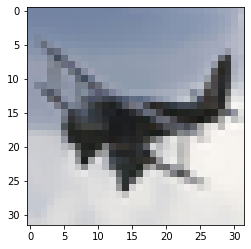

In [15]:
from torch.utils.data import DataLoader

dataloaders = {}
dataloaders["train"] = DataLoader(dataset=train_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=True)

dataloaders["test"] = DataLoader(dataset=test_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=True)

dataloaders["noise"] = DataLoader(dataset=noise_set,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=True)

images = next(iter(dataloaders["test"]))
plt.imshow(np.transpose(images[0], (1,2,0)))


In [16]:
# epoch = 2000
# train_losses = []
# val_losses = []

# print("Training started!")

# for e in range(1, epoch+1):
#     if e == 1800:
#         for g in optimizer.param_groups:
#             g['lr'] = 1e-06
#         print("Changed learningrate")

#     train_loss = 0.0
#     for x in dataloaders["train"]:
#         x = x.to(device)
#         x_recon, mu, log_var = model(x)

#         optimizer.zero_grad()
#         loss = loss_fn(x, x_recon, mu, log_var)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()
    
#     val_loss = 0.0
#     for x in dataloaders["test"]:
#         x = x.to(device)
#         x_recon, mu, log_var = model(x)

#         optimizer.zero_grad()
#         loss = loss_fn(x, x_recon, mu, log_var)

#         val_loss += loss.item()
    
#     train_losses.append(train_loss)
#     val_losses.append(val_loss)
#     train_loss /= len(dataloaders["train"].dataset)
#     val_loss /= len(dataloaders["test"].dataset)

#     print(f"Epoch {e} | Loss: {train_loss} | V_Loss: {val_loss}")


In [17]:

# plt.figure(figsize=(10,5))
# plt.title("Training and Validation Loss")
# plt.plot(val_losses[15:],label="val")
# plt.plot(train_losses[15:],label="train")
# plt.xlabel("iterations")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

In [18]:
def printReconError(img_in, img_out, threshold=None):
    img_in = img_in.dot([0.07, 0.72, 0.21])
    img_out = img_out.dot([0.07, 0.72, 0.21])
    errorMatrix = np.absolute(img_in - img_out)
    if not threshold == None:
        errorMatrix[errorMatrix < threshold] = 0.0
    errorAvg = np.sum(errorMatrix) / (errorMatrix.shape[0] * errorMatrix.shape[1])
    print(f"MAE: {errorAvg}")
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
    
    ax1.set_title("Original")
    ax1.imshow(img_in, cmap="gray")
    ax2.set_title("Recreation")
    ax2.imshow(img_out, cmap="gray")
    ax3.set_title("ErrorMap")
    ax3.imshow(errorMatrix, cmap="gray")

torch.Size([128, 3, 32, 32])
float32
(32, 32, 3)
(32, 32, 3)


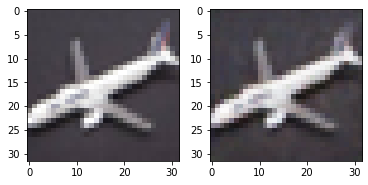

In [19]:
import random

with torch.no_grad():
    for imgs in random.sample(list(dataloaders["train"]), 1):
#         imgs, _ = data
        imgs = imgs.to(device)
        print(imgs.shape)
#         img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        img = imgs[0].cpu().numpy()
        img = np.transpose(img, (1,2,0))
        print(img.dtype)
        print(img.shape)
        plt.imshow(img)
        out, mu, logVAR = model(imgs)
#         outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        out = out[0].cpu().numpy()
        out = np.transpose(out, (1,2,0))

        print(out.shape)
        plt.imshow(out)
        break

MAE: 0.0029045248855254615


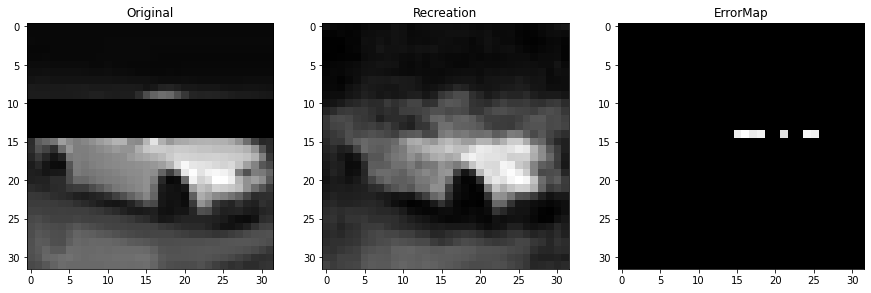

In [20]:
import random

# model.eval()
with torch.no_grad():
    for imgs in random.sample(list(dataloaders["noise"]), 1):
        imgs = imgs.to(device)
#         plt.subplot(121)
        img = imgs[0].cpu().numpy()
        img = np.transpose(img, (1,2,0))
#         plt.imshow(img, cmap="gray")
        
        out, mu, logVAR = model(imgs)
#         plt.subplot(122)
        out = out[0].cpu().numpy()
        out = np.transpose(out, (1,2,0))
#         plt.imshow(out, cmap="gray")
        
        printReconError(img, out, 0.4)
        break

In [21]:
tmp = []
tmp.append(img)
tmp = np.array(tmp)
tmp.shape

(1, 32, 32, 3)

In [22]:
# torch.save(model.state_dict(), PATH)

In [23]:
x = int(4.6)
x

4